# Chapter 5.1.1

This notebook covers the content in Chapter 5.1.1, which introduces classical time-series momentum strategies and volatility targeting. 

In [1]:
import os 
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from Utilis.metrics import report_metrics
# import yfinance as yf


In [2]:
def rolling_std(arr, window_size):
    rolled = np.lib.stride_tricks.sliding_window_view(arr, window_shape=window_size)
    stds = rolled.std(axis=-1)
    return stds

### Long Only and Volatility Targeting

Let us start with the simplest benchmark strategy, long-only strategy, which is holding an asset to the end. I will then incorporate the idea of volatility targeting to it. 

In [3]:
df = pd.read_csv('../Data/aapl.csv')
df.head()

,Close,High,Low,Open,Volume,Ticker
0,0.771149,0.832276,0.761274,0.814408,512377600,AAPL
1,0.782433,0.831806,0.774910,0.780552,778321600,AAPL
2,0.714723,0.805004,0.714723,0.798421,767972800,AAPL
3,0.748578,0.759864,0.718485,0.726008,460734400,AAPL
4,0.735412,0.769267,0.712842,0.767386,505064000,AAPL


In [6]:
# Let us use log return
df['returns'] = np.log(df['Close']/df['Close'].shift(1))
df['future_returns'] = np.log(df['Close'].shift(-1)/df['Close'])

# Long-only Strategy
df["long_only_position"] = 1.0  # Full allocation
df["long_only_strategy_ret"] = df["long_only_position"] * df["future_returns"]
df["long_only_cumret"] = df["long_only_strategy_ret"].cumsum()

# Long-only strategy with volatility targeting
sigma_tgt = 0.15/np.sqrt(252)
lookback = 60  # e.g. rolling 20-day

df["realized_vol_daily"] = df["returns"].ewm(lookback).std()
# df["realized_vol_annual"] = df["realized_vol_daily"] * np.sqrt(252)

df["vol_target_position"] = sigma_tgt / df["realized_vol_daily"]
# We can fill with no position or hold a default position (e.g., 1.0).
df["vol_target_position"].fillna(value=0.0, inplace=True)
df["vol_target_strategy_ret"] = df["vol_target_position"] * df["future_returns"]
df["vol_target_cumret"] = (df["vol_target_strategy_ret"]).cumsum()


/var/folders/9f/3_fg55yx57j31bk6h9qrdvf80000gn/T/ipykernel_9933/831835216.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["vol_target_position"].fillna(value=0.0, inplace=True)


In [7]:
# we can see that the annual volatlity is closed to 0.15 and the volatility targeting approach delivers a higher sharpe ratio
print(report_metrics(df['long_only_strategy_ret']))
print(report_metrics(df['vol_target_strategy_ret']))

{'annual_ret': np.float64(0.23207562317254699), 'annual_std': np.float64(0.40048109633932033), 'annual_sharpe': np.float64(0.5794920791365232)}
{'annual_ret': np.float64(0.1305485779072901), 'annual_std': np.float64(0.1530081029534804), 'annual_sharpe': np.float64(0.8532134925362826)}


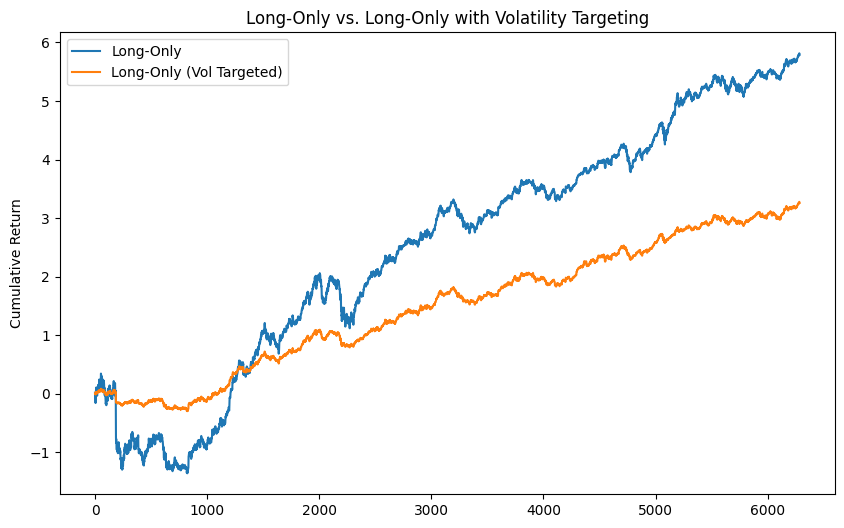

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df["long_only_cumret"], label="Long-Only")
plt.plot(df["vol_target_cumret"], label="Long-Only (Vol Targeted)")
plt.title("Long-Only vs. Long-Only with Volatility Targeting")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

### Classical Time-series Momentum Strategies: TSMOM, Simple Moving Average Crossover (SMA) and MACD

Let us introdce three classical time-series strategies.


In [9]:
def create_TSMOM(price):
    past_year_return = price.pct_change(252)
    position = np.sign(past_year_return)
    return position

def create_SMA(price, k1, k2):
    price_k1 = price.rolling(k1).mean()
    price_k2 = price.rolling(k2).mean()
    position = price_k1 - price_k2
    return position / position.rolling(k2).std()

def create_MACD(price, k1, k2):
    price_k1 = price.ewm(k1).mean()
    price_k2 = price.ewm(k2).mean()
    position = price_k1 - price_k2
    position = position / position.rolling(k2).std()
    return position

def create_MACD_combine(price, s_list, l_list):
    positions = np.zeros((len(price), len(s_list)))
    for i, (s, l) in enumerate(zip(s_list, l_list)):
        positions[:, i] = create_MACD(price, s, l)
    positions = np.mean(positions, axis=1)
    return positions

In [10]:
sigma_tgt_TSMOM = 0.15/np.sqrt(252)
df['TSMOM_position'] = sigma_tgt_TSMOM / df["realized_vol_daily"] * create_TSMOM(df['Close'])
df["TSMOM_ret"] = df["TSMOM_position"] * df["future_returns"]
df["TSMOM_cumret"] = (df["TSMOM_ret"]).cumsum()

sigma_tgt_sma = 0.07/np.sqrt(252)
df['SMA_position'] = sigma_tgt_sma / df["realized_vol_daily"] * create_SMA(df['Close'], 10, 40)
df["SMA_ret"] = df["SMA_position"] * df["future_returns"]
df["SMA_cumret"] = (df["SMA_ret"]).cumsum()

sigma_tgt_macd = 0.03/np.sqrt(252)
df['MACD_position'] = sigma_tgt_macd / df["realized_vol_daily"] * create_MACD_combine(df['Close'], [8, 16, 32], [24, 48, 96])
df["MACD_ret"] = df["MACD_position"] * df["future_returns"]
df["MACD_cumret"] = (df["MACD_ret"]).cumsum()

In [11]:
print(report_metrics(df['long_only_strategy_ret']))
print(report_metrics(df['vol_target_strategy_ret']))
print(report_metrics(df['TSMOM_ret']))
print(report_metrics(df['SMA_ret']))
print(report_metrics(df['MACD_ret']))

{'annual_ret': np.float64(0.23207562317254699), 'annual_std': np.float64(0.40048109633932033), 'annual_sharpe': np.float64(0.5794920791365232)}
{'annual_ret': np.float64(0.1305485779072901), 'annual_std': np.float64(0.1530081029534804), 'annual_sharpe': np.float64(0.8532134925362826)}
{'annual_ret': np.float64(0.0813013740859546), 'annual_std': np.float64(0.15048137739244982), 'annual_sharpe': np.float64(0.5402753184131459)}
{'annual_ret': np.float64(0.06511008768504611), 'annual_std': np.float64(0.16116649226868154), 'annual_sharpe': np.float64(0.40399270821443917)}
{'annual_ret': np.float64(0.08102689114431401), 'annual_std': np.float64(0.15026764443430077), 'annual_sharpe': np.float64(0.5392171511661659)}


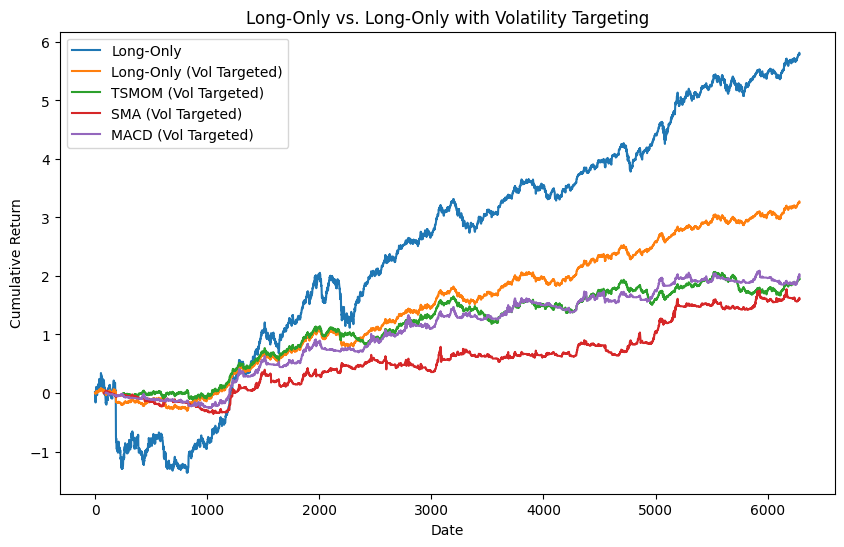

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df["long_only_cumret"], label="Long-Only")
plt.plot(df["vol_target_cumret"], label="Long-Only (Vol Targeted)")
plt.plot(df["TSMOM_cumret"], label="TSMOM (Vol Targeted)")
plt.plot(df["SMA_cumret"], label="SMA (Vol Targeted)")
plt.plot(df["MACD_cumret"], label="MACD (Vol Targeted)")

plt.title("Long-Only vs. Long-Only with Volatility Targeting")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()